In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn')

# 讀入資料

In [2]:
Fed_fund_rate_fitted_result = pd.read_csv(
    '/Users/andy/Desktop/RA project for professor Yueh/2020:3 - 2020:6/New Version (Different T)/data/Fed_fund_rate_fitted_result.csv'
)

sigma_r_square_collection = pd.read_excel(
    '/Users/andy/Desktop/RA project for professor Yueh/2020:3 - 2020:6/New Version (Different T)/data/Calibration_result_from Leo-Numerix(arranged).xlsx'
)

Matched_sigma_r_square_Tenor = pd.read_excel(
    'Matched_sigma_r_square_Tenor.xlsx'
)

In [3]:
Fed_fund_rate_fitted_result.head()

,Required Tenor,Zero_Rate_Cubic_spline,Discount_Factor_Cubic_spline,Zero_Rate_NS,Discount_Factor_NS,Zero_Rate_NSS,Discount_Factor_NSS
0,0.011111,0.015773,0.999825,0.016425,0.999818,0.014951,0.999834
1,0.083333,0.016100,0.998659,0.016218,0.998649,0.014933,0.998756
2,0.169444,0.016044,0.997285,0.015982,0.997296,0.014911,0.997477
3,0.252778,0.015950,0.995976,0.015763,0.996023,0.014890,0.996243
4,0.338889,0.015822,0.994653,0.015548,0.994745,0.014869,0.994974


In [4]:
sigma_r_square_collection

,Unnamed: 0,0.012,0.01,0.03,0.05
0,1m,0.006251,0.006235,0.006517,0.006807
1,3m,0.005341,0.005331,0.005502,0.005677
2,6m,0.005041,0.005035,0.005137,0.005239
3,1y,0.004934,0.004928,0.005021,0.005114
4,2y,0.006674,0.006625,0.007443,0.008246
5,5y,0.006174,0.006124,0.006989,0.007890
6,10y,0.005645,0.005521,0.007581,0.009626
7,15y,0.005384,0.005303,0.006709,0.008183
8,20y,0.004898,0.004763,0.007039,0.009374
9,25y,0.005704,0.005621,0.007051,0.008537


In [5]:
Matched_sigma_r_square_Tenor.head()

,Required Tenor,Macthed sigma r square Tenor
0,0.011111,1m
1,0.083333,1m
2,0.169444,3m
3,0.252778,3m
4,0.338889,6m


# 整理資料

In [6]:
# 重新命名column
sigma_r_square_collection.rename(columns={'Unnamed: 0': 'Maturity'}, inplace=True)

# 把Maturity欄位存到index，目的是之後要變成dict，方便後續步驟拿值
sigma_r_square_collection.index = sigma_r_square_collection.Maturity

# 把Maturity欄位drop掉
sigma_r_square_collection.drop(columns='Maturity', inplace=True)

sigma_r_square_collection.head()

,0.012,0.010,0.030,0.050
Maturity,,,,
1m,0.006251,0.006235,0.006517,0.006807
3m,0.005341,0.005331,0.005502,0.005677
6m,0.005041,0.005035,0.005137,0.005239
1y,0.004934,0.004928,0.005021,0.005114
2y,0.006674,0.006625,0.007443,0.008246


In [7]:
# 把Matched_sigma_r_square_Tenor與Fed_fund_rate_fitted_result併在一起
# 原本想要依據Required Tenor將兩張表merge在一起，但是發現因為浮點數關係會無法串在一起
# 因此在知道兩張表的Required Tenor長度與排序一樣情況下可以直接用join接起來
Fed_fund_rate_fitted_result = Fed_fund_rate_fitted_result.join(
    Matched_sigma_r_square_Tenor['Macthed sigma r square Tenor']
)

Fed_fund_rate_fitted_result.head()

,Required Tenor,Zero_Rate_Cubic_spline,Discount_Factor_Cubic_spline,Zero_Rate_NS,Discount_Factor_NS,Zero_Rate_NSS,Discount_Factor_NSS,Macthed sigma r square Tenor
0,0.011111,0.015773,0.999825,0.016425,0.999818,0.014951,0.999834,1m
1,0.083333,0.016100,0.998659,0.016218,0.998649,0.014933,0.998756,1m
2,0.169444,0.016044,0.997285,0.015982,0.997296,0.014911,0.997477,3m
3,0.252778,0.015950,0.995976,0.015763,0.996023,0.014890,0.996243,3m
4,0.338889,0.015822,0.994653,0.015548,0.994745,0.014869,0.994974,6m


# 指定參數

In [8]:
k = 0.01 # 0.01, 0.03
theta = 0.01 # 0.012, 0.01, 0.03, 0.05

# 先前fit Fed Fund rate使用的model(目前預設為Cubic Spline)
Fed_fund_rate_fitted_result_used_model = 'Cubic_spline'

# 指定相關變數

In [9]:
# 之後要從Fed_fund_rate_fitted_result選擇欄位的名稱
# 與上方Fed_fund_rate_fitted_result_used_model變數連動
select_column = 'Discount_Factor_' + Fed_fund_rate_fitted_result_used_model

# 用dict形式方便讀取值
discount_factor_dict = dict(zip(
    Fed_fund_rate_fitted_result['Required Tenor'],
    Fed_fund_rate_fitted_result[select_column]
))

# 因為會需要0，可是原始資料中沒有，因此自己加上，T=0的折現為Discount factor為1
discount_factor_dict[0] = 1

In [10]:
# 建立給定Tenor對應sigma_r_square值的dict
# example: {
#     '1m': 0.00623488457694546,
#     '3m': 0.00533050349235285,
#     .....
# }
sigma_r_square_series_for_match = dict(
    sigma_r_square_collection[theta]
)

# 在Fed_fund_rate_fitted_result中建立T1, T2，給for loop跑
Fed_fund_rate_fitted_result['T2'] = Fed_fund_rate_fitted_result['Required Tenor']
Fed_fund_rate_fitted_result['T1'] = Fed_fund_rate_fitted_result['T2'].shift()
Fed_fund_rate_fitted_result.T1.fillna(0, inplace=True)

# 建立給定Required_Tenor對應Tenor的dict
# example: {
#     0.011111111111111113: '1m',
#     0.08333333333333333: '1m',
#      ......
# }
sigma_r_square_matching_Tenor = dict(zip(
    Fed_fund_rate_fitted_result['T2'],
    Fed_fund_rate_fitted_result['Macthed sigma r square Tenor']
))

# 建立function接受到T後透過sigma_r_square_matching_Tenor找到對應Tenor
# 再去向sigma_r_square_series_for_match找對應的sigma_r_square
def select_sigma_r_square(T):
    return sigma_r_square_series_for_match[
        sigma_r_square_matching_Tenor[T]
    ]

# 估計phi(T1, T2)

In [11]:
def estimate_phi_t(T1, T2):
    # print出來方便檢查
    print('T1: {}'.format(T1))
    print('T2: {}'.format(T2))
    print('P_T1: {}'.format(discount_factor_dict[T1]))
    print('P_T2: {}'.format(discount_factor_dict[T2]))
    print('sigma_r_square: {}'.format(select_sigma_r_square(T2)))
    print('')
    
    return (
        (
            discount_factor_dict[T1] / discount_factor_dict[T2]
        ) *
        np.exp(
            (
                0.5 * select_sigma_r_square(T2) / (k**2)
            ) * 
            (
                (T2 - T1) -
                (2/k) * (1-np.exp(-k*(T2 - T1))) +
                (1/(2*k)) * (1-np.exp(-2*k*(T2 - T1)))
            )
        )
    )

In [12]:
# 執行上述function
phi_t_collection = pd.DataFrame()

for i in range(len(Fed_fund_rate_fitted_result)):
    T_1 = Fed_fund_rate_fitted_result['T1'].values[i]
    T_2 = Fed_fund_rate_fitted_result['T2'].values[i]
    current_phi_t = estimate_phi_t(T_1, T_2)
    used_sigma_r_square = select_sigma_r_square(T_2)
    
    temp_phi_t_collection = pd.DataFrame([[
        T_1, T_2, used_sigma_r_square, current_phi_t
    ]], columns=[
        'T_1', 'T_2', 'used_sigma_r_square', 'phi_t'
    ])
    
    phi_t_collection = pd.concat([phi_t_collection, temp_phi_t_collection])

# 由於實際上要的值是phi_t取完log後的值，因此最後還要取log才是對的
phi_t_collection['phi_t_after_log'] = phi_t_collection['phi_t'].apply(lambda x: np.log(x)) 

T1: 0.0
T2: 0.011111111111111113
P_T1: 1
P_T2: 0.9998247627581224
sigma_r_square: 0.00623488457694546

T1: 0.011111111111111113
T2: 0.08333333333333333
P_T1: 0.9998247627581224
P_T2: 0.9986592499456408
sigma_r_square: 0.00623488457694546

T1: 0.08333333333333333
T2: 0.16944444444444445
P_T1: 0.9986592499456408
P_T2: 0.9972851669245654
sigma_r_square: 0.00533050349235285

T1: 0.16944444444444445
T2: 0.25277777777777777
P_T1: 0.9972851669245654
P_T2: 0.995976430269488
sigma_r_square: 0.00533050349235285

T1: 0.25277777777777777
T2: 0.33888888888888896
P_T1: 0.995976430269488
P_T2: 0.9946525687413816
sigma_r_square: 0.00503540491614152

T1: 0.33888888888888896
T2: 0.4222222222222222
P_T1: 0.9946525687413816
P_T2: 0.9934194601691012
sigma_r_square: 0.00503540491614152

T1: 0.4222222222222222
T2: 0.5083333333333333
P_T1: 0.9934194601691012
P_T2: 0.992164408914406
sigma_r_square: 0.00503540491614152

T1: 0.5083333333333333
T2: 0.5944444444444444
P_T1: 0.992164408914406
P_T2: 0.99095919231882

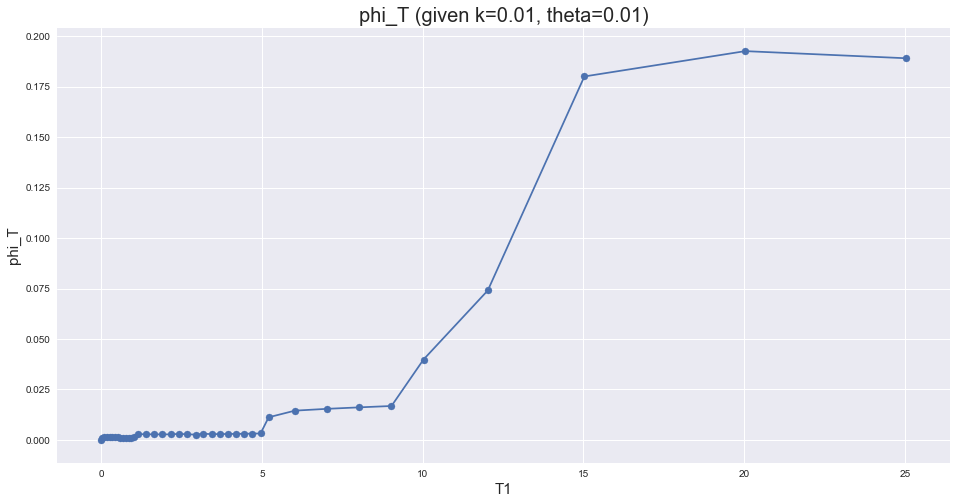

In [13]:
plt.figure(figsize=(16, 8), facecolor='white')
plt.plot(
     phi_t_collection.T_1,
     phi_t_collection.phi_t_after_log
)
plt.scatter(
     phi_t_collection.T_1,
     phi_t_collection.phi_t_after_log
)
plt.title('phi_T (given k={}, theta={})'.format(k, theta), fontsize=20)
plt.xlabel('T1', fontsize=15)
plt.ylabel('phi_T', fontsize=15);

# 把結果存成CSV

In [14]:
# 去除不必要的欄位
phi_t_collection.drop(columns=['T_1', 'used_sigma_r_square', 'phi_t'], inplace=True)

# 將T_2(原先的Required Tenor)命名回Required Tenor
# 將phi_t_after_log(最後要的結果)命名為phi(T1, T2)
phi_t_collection.rename(
    columns={
        'T_2': 'Required Tenor',
        'phi_t_after_log': 'phi(T1, T2)'
    },
    inplace=True
)

phi_t_collection.head()

,Required Tenor,"phi(T1, T2)"
0,0.011111,0.000175
0,0.083333,0.001167
0,0.169444,0.001377
0,0.252778,0.001314
0,0.338889,0.001331


In [15]:
# 儲存結果
phi_t_collection.to_csv('phi(T1, T2).csv', index=False)